## MULTIVARIATE PARTIAL LEAST SQUARES REGRESSION FOR MICROBIOME COMPOSITION FORECST

In [ ]:
import pandas as pd
import numpy as np
import warnings 
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

import skbio
from skbio.stats.composition import clr

import scipy
from scipy import stats

from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

MODULE_PATH = os.path.abspath('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/data-preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit
from interpolation import Interpolation

MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from utils.measures import calculate_nrmse, calculate_spearman, intra_dissimilarity, inter_dissimilarity

In [4]:
%cd /storage/zkarwowska/predicting-microbiome-in-time/linear-models/pls-regression/

/storage/zkarwowska/predicting-microbiome-in-time/linear-models/pls-regression


In [22]:
FILE_PATH = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction/male_assigned_sample_names.csv'

#read file
DF = pd.read_csv(FILE_PATH, index_col=[0])
DF = DF.sort_index()

#interpolate
interpolator = Interpolation()
INTERPOLATED_DF = interpolator.interpolate_pchip(DF).astype(float)

#change to prc
INTERPOLATED_PRC = INTERPOLATED_DF.div(INTERPOLATED_DF.sum(axis=1), axis=0) + 1e-9

#transform using clr
CLR_DF = pd.DataFrame(clr(INTERPOLATED_PRC), columns=DF.columns)

#filter rare bacteria 
processing = MicrobiomeDataPreprocessing()
KEEP_COLUMNS = processing.filter_rare_features(INTERPOLATED_DF, treshold_perc=0.9).columns

# remove rare bacteria from clr dataset
FILTERED_CLR_DF = CLR_DF[KEEP_COLUMNS]


def pls_cv(X, y, n_comp):
    
    '''
    choose a good number of pls components based on bray curtis dissimilarity
    '''
    
    pls = PLSRegression(n_components=n_comp,  scale=False)
    y_cv = cross_val_predict(pls, X, y, cv=10)

    yhat_cv_df = pd.DataFrame(y_cv, columns = y.columns,index=y.index)
    
    bc = inter_dissimilarity(yhat_cv_df, y, 'bc')['bc'].median()
    
    return y_cv, bc

def pls_choose_comp_number(X_train, y_train, n_comp=5):
    
    bcs = []
    xticks = np.arange(1, n_comp)
    
    for n_comp in xticks:
        y_cv, bc = pls_cv(X_train, y_train, n_comp)
        bcs.append(bc)
    
    best_n_comp = pd.DataFrame(bcs).sort_values(by = [0]).head(1).index.tolist()[0]

    return best_n_comp

def predict_with_pls(df, lag):
    
    '''
    
    predict microbiome with pls regresison
    
    params
    ------
    
    df - feature table
    lag - how many days ahead we use to predict
    
    returns
    -------
    
    PREDICTION - dataframe with predicted microbiome composition
    COFFICIENTS - dataframe with regression coefficients
    
    '''

    #change dataset to supervised
    processing = MicrobiomeDataPreprocessing()
    SUPERVISED_DF = processing.make_supervised(df, lag)

    #split to train and test
    split = MicrobiomeTraintestSplit(prc_split=0.1)
    train, test = split.last_block_split(SUPERVISED_DF)

    y_train = train.filter(like = 'lag0')
    y_test = test.filter(like = 'lag0')

    X_train = train.drop(train.filter(regex='lag0').columns, axis=1)
    X_test = test.drop(test.filter(regex='lag0').columns, axis=1)

    #choose number of components
    n_comps = pls_choose_comp_number(X_train, y_train)

    #fit pls regression with the best number of components
    pls = PLSRegression(n_components=n_comps, scale=True)
    pls.fit(X_train, y_train)

    #predict
    yhat = pls.predict(X_test)

    #regression prediction
    PREDICTION = pd.DataFrame(yhat, columns = df.columns)

    #regression coefficients
    COFFICIENTS = pd.DataFrame(pls.coef_)
    COFFICIENTS.index = SUPERVISED_DF.drop(SUPERVISED_DF.filter(like ='lag0').columns, axis=1).columns
    COFFICIENTS.columns = SUPERVISED_DF.filter(like ='lag0').columns
    
    TRUE = y_test.reset_index(drop=True)
    TRUE.columns = PREDICTION.columns
    
    return TRUE, PREDICTION, COFFICIENTS, 

In [23]:
TRUE, PREDICTION, COEFF = predict_with_pls(FILTERED_CLR_DF, 1)

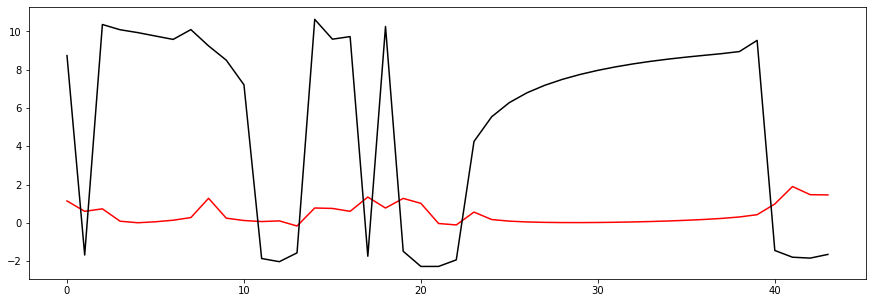

In [26]:
plt.figure(figsize = (15, 5))
plt.plot(PREDICTION.iloc[:, 0], color='red')
plt.plot(TRUE.iloc[:, 0], color='black')